In [1]:
import os
os.chdir("..")

from pprint import pprint
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tuxai.dataset import Dataset, Columns
from tuxai.misc import config_logger, get_config
from tuxai.report import model_metrics, Report, FeatureImportanceReport

config_logger()
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100


# Yes frequencies

In [3]:
fir = FeatureImportanceReport(use_cache="fi_const_2023")

2023-02-07 10:56:51,902 :: INFO :: tuxai.report :: loading feature importance data from cache: fi_const_2023


In [4]:

df_ai = fir.options_always_importants(target="vmlinux", rank=99999, collinearity=True, merge_groups=False, allow_version_gap=True).set_index("options")
df = fir.add_yes_frequencies(df_ai, str_pct=False)
df

  0%|          | 0/12369 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,4.13,4.15,4.20,5.00,5.04,5.07,5.08,freq 4.13,freq 4.15,freq 4.20,freq 5.00,freq 5.04,freq 5.07,freq 5.08
104_QUAD_8,128,419,48,38,60,96,77,0.054364,0.052276,0.103495,0.107408,0.060781,0.058336,0.061625
60XX_WDT,78,53,35,34,49,62,42,0.246818,0.247163,0.245775,0.245940,0.244284,0.251153,0.249646
"64BIT, ARCH_FLATMEM_ENABLE, ARCH_HAS_KCOV, ARCH_HAS_PMEM_API, ARCH_HAS_UACCESS_FLUSHCACHE, ARCH_HAS_ZONE_DEVICE, ARCH_SPARSEMEM_DEFAULT, ARCH_SUPPORTS_INT128, ARCH_SUPPORTS_NUMA_BALANCING, ARCH_USE_CMPXCHG_LOCKREF, ARCH_WANTS_THP_SWAP, ARCH_WANT_IPC_PARSE_VERSION, AUDIT_ARCH, CLKSRC_I8253, CLONE_BACKWARDS, GENERIC_CPU, HARDLOCKUP_CHECK_TIMESTAMP, HAVE_AOUT, HAVE_ARCH_SOFT_DIRTY, HAVE_ARCH_TRANSPARENT_HUGEPAGE_PUD, HAVE_ARCH_VMAP_STACK, HAVE_ATOMIC_IOMAP, HAVE_CONTEXT_TRACKING, HAVE_EBPF_JIT, HAVE_GENERIC_DMA_COHERENT, HAVE_IRQ_EXIT_ON_IRQ_STACK, HAVE_LIVEPATCH, HAVE_STACK_VALIDATION, HAVE_VIRT_CPU_ACCOUNTING_GEN, LEGACY_VSYSCALL_EMULATE, MODULES_USE_ELF_REL, MODULES_USE_ELF_RELA, OLD_SIGACTION, SPARSEMEM_ALLOC_MEM_MAP_TOGETHER, SPARSEMEM_EXTREME, SPARSEMEM_STATIC, SPARSEMEM_VMEMMAP_ENABLE, X86_32, X86_32_LAZY_GS, X86_64, X86_DEV_DMA_OPS, X86_USE_PPRO_CHECKSUM, ZONE_DMA32",3790,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.999665,NaN,NaN,NaN,NaN,NaN,NaN
6LOWPAN,89,488,71,55,222,63,38,0.065513,0.068017,0.066244,0.063753,0.064340,0.080510,0.083383
6LOWPAN_DEBUGFS,64,2034,457,1542,550,1595,115,0.053575,0.052835,0.052280,0.050321,0.053662,0.061213,0.061260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZX_DMA,4214,4408,4816,4928,5037,5355,5373,0.158629,0.157438,0.147942,0.143494,0.148412,0.155365,0.148109
ZX_I2S,7932,7894,8635,8644,9230,9738,9872,0.031287,0.030822,0.026949,0.034182,0.035749,0.034426,0.043425
ZX_SPDIF,3396,3608,4024,4067,4194,4393,4383,0.030434,0.030340,0.026651,0.033881,0.034356,0.033385,0.042786
ZX_TDM,7437,894,8208,8306,8337,797,802,0.060554,0.061137,0.053429,0.071822,0.069989,0.070043,0.091365


In [14]:
def detect_outliers(row):
    row = [i for i in row if i != np.nan]
    q1, q3 = np.percentile(row, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return [x for x in row if x < lower_bound or x > upper_bound]

def outliers_score(row):
    outliers = detect_outliers(row)
    if not outliers:
        return 0
    mean = np.mean(row)
    score = sum([abs(x - mean) for x in outliers]) / len(outliers)
    return score

freq_cols = [col for col in df.columns if col.startswith("freq")]
df["outliers_score"] = df[freq_cols].apply(lambda row: outliers_score(row), axis=1)
df["outliers"] = df[freq_cols].apply(lambda row: detect_outliers(row), axis=1)

df[df.outliers_score > 0.1].sort_values("outliers_score", ascending=False)

,4.13,4.15,4.20,5.00,5.04,5.07,5.08,freq 4.13,freq 4.15,freq 4.20,freq 5.00,freq 5.04,freq 5.07,freq 5.08,outliers_score,outliers
UBSAN_ALIGNMENT,8,8,7,8,9,9,9,0.166850,0.250946,0.238409,0.256265,0.748868,0.121931,0.126579,0.476033,[0.7488683406198011]
PINCTRL,8432,8526,9176,9311,9700,10168,10340,0.314805,0.659761,0.861850,0.882618,0.880721,0.882732,0.880901,0.451393,[0.3148052116419265]
PINMUX,5686,704,6392,6458,6732,7102,7160,0.314751,0.643385,0.854570,0.878508,0.877742,0.878317,0.870091,0.444872,[0.3147511937944297]
CEC_NOTIFIER,4736,4895,5381,5469,506,5857,5978,0.073421,0.213040,0.543531,0.550571,0.562154,0.568580,0.691967,0.384188,[0.07342105831766815]
VIDEO_V4L2_SUBDEV_API,5979,6132,6043,6114,7052,7448,7480,0.138804,0.137787,0.140236,0.139234,0.152358,0.146585,0.539935,0.340658,[0.5399352278429047]
PM_OPP,6756,6884,7494,836,7196,8322,8414,0.322314,0.633458,0.637362,0.637079,0.720200,0.816658,0.824796,0.333667,[0.3223136924439835]
RPMSG,492,5823,6317,6436,6651,7037,7099,0.268112,0.615178,0.623015,0.669006,0.661702,0.668138,0.667655,0.328003,[0.2681121842656814]
CRYPTO_SEQIV,5087,5229,5751,5817,5902,6245,6394,0.960643,0.969558,0.971646,0.971532,0.955469,0.953867,0.611778,0.301721,[0.6117775851845094]
PRIME_NUMBERS,216,107,792,783,853,5101,5102,0.262073,0.264377,0.257695,0.257468,0.255426,0.260182,0.594946,0.287494,[0.594945947178762]
MEDIA_CONTROLLER,8458,8628,9335,468,9815,10335,10527,0.285139,0.290451,0.294138,0.287039,0.314737,0.302793,0.602928,0.263325,[0.6029284313278293]


# Quantify feature importance with respect to kernel size

## Each target for 4.13

<AxesSubplot: >

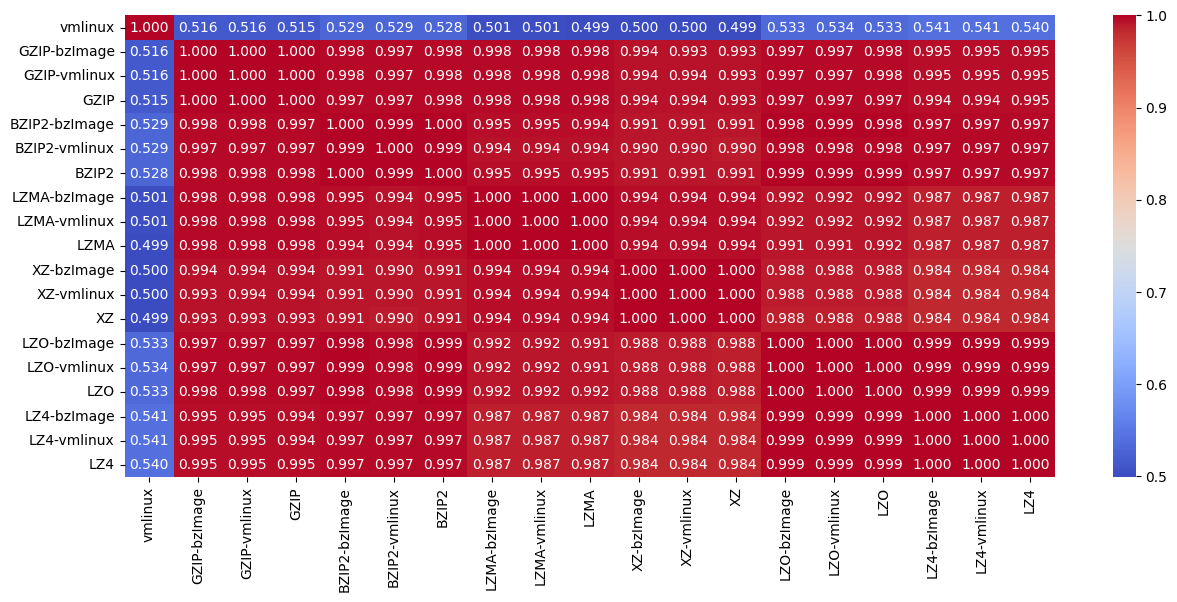

In [54]:
plt.figure(figsize=(15, 6))
df_413 = Dataset(413).get_dataframe(Columns.targets)
mat_413 = df_413.corr()
sns.heatmap(mat_413, annot=True, cmap="coolwarm", fmt=".3f")

## without vmlinux

<AxesSubplot: >

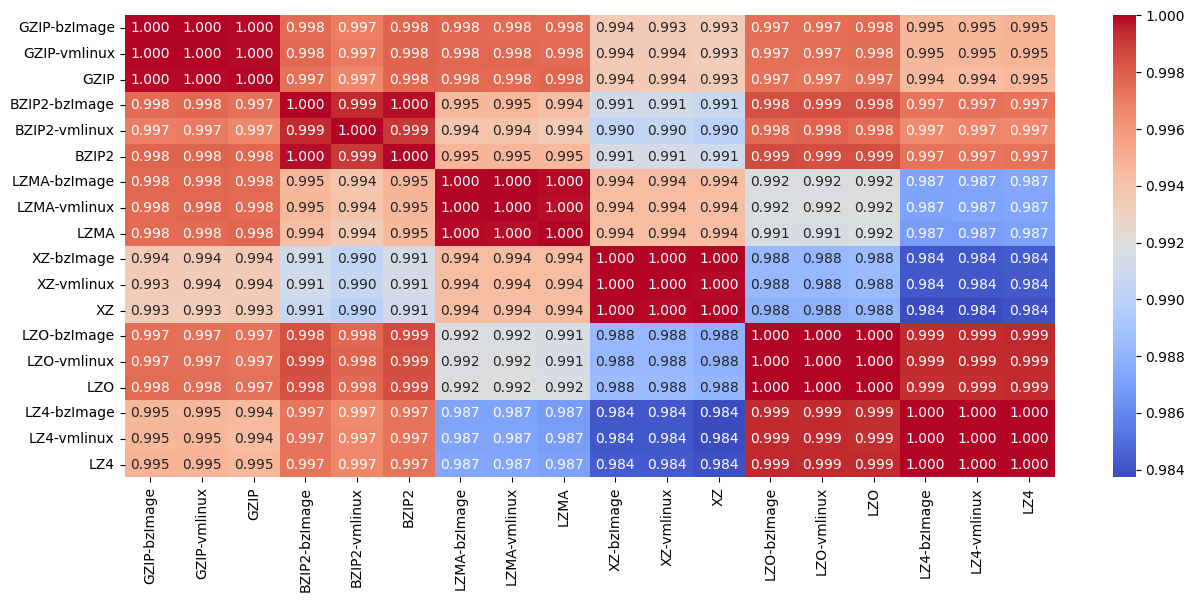

In [59]:
targets = list(df_413.columns)
targets.remove("vmlinux")
plt.figure(figsize=(15, 6))
df_413 = Dataset(413).get_dataframe(Columns.targets)[targets]
mat_413 = df_413.corr()
sns.heatmap(mat_413, annot=True, cmap="coolwarm", fmt=".3f")

## without vmlinux and duplicated compressed targets

In [60]:
versions = get_config()["report"]["versions"]
targets = [col for col in df_413.columns if not col.endswith("vmlinux") and not col.endswith("bzImage")]
mats = {
    version: Dataset(version).get_dataframe(Columns.targets)[targets].corr()
    for version in versions
    }

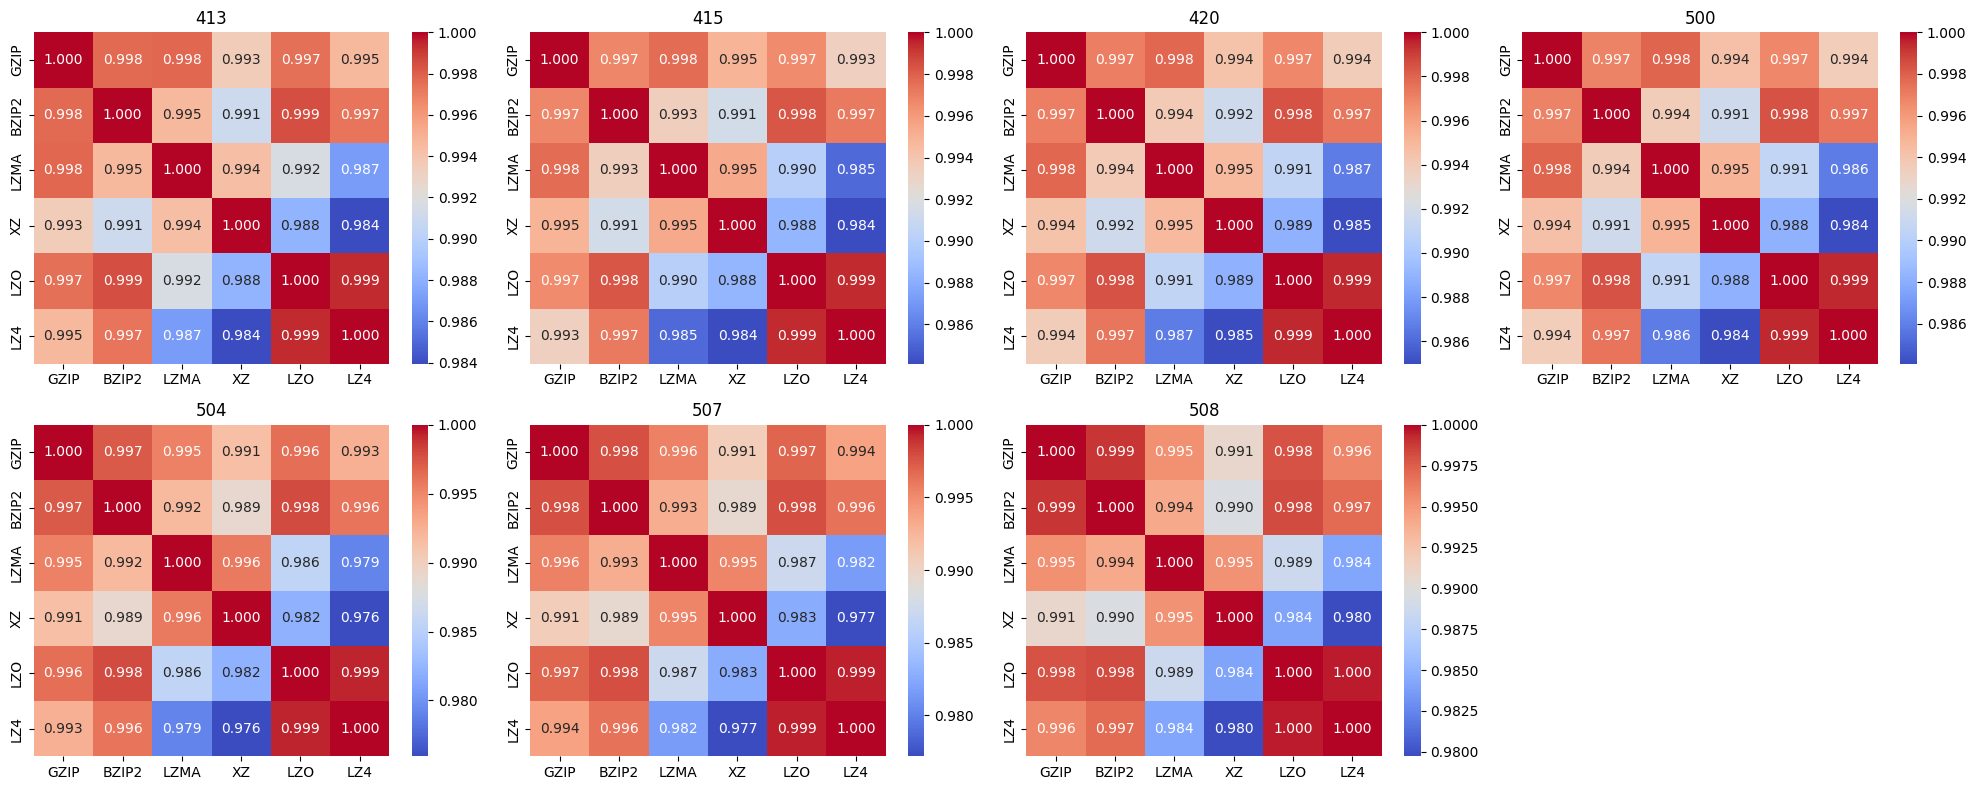

In [67]:

plt.figure(figsize=(20, 8))
for i, (version, mat) in enumerate(mats.items()):
    plt.subplot(1 + len(versions) // 4, 4, i + 1)
    plt.title(version)
    df = mats[version]
    sns.heatmap(mats[version], annot=True, fmt=".3f", cmap="coolwarm")
plt.tight_layout()

# Feature impact on kernel size

In [3]:
df_413_x = Dataset(413).get_dataframe(Columns.options)
df_413_y = Dataset(413).get_dataframe(Columns.targets)
df = df_413_x.copy()
df["vmlinux"] = df_413_y["vmlinux"]
df

,OPENVSWITCH,CORR|0001,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,NETFILTER_XT_MATCH_TIME,NET_MPLS_GSO,NFC_SHDLC,NETFILTER_XT_MATCH_U32,OPENVSWITCH_GRE,...,APDS9960,SLABINFO,MICROCODE_AMD,ISDN_DRV_HISAX,CHARGER_BQ24190,SND_SOC_NAU8825,BH1750,NETWORK_FILESYSTEMS,nb_yes,vmlinux
0,False,False,False,True,False,False,True,False,False,False,...,False,False,False,False,True,False,False,False,0.124740,47.895546
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,0.123932,15.888237
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,0.151074,41.085106
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,False,True,False,True,False,0.209286,25.998756
4,False,False,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,True,True,0.265304,56.046906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92557,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000116,6.978043
92558,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000116,6.978043
92559,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000116,6.978043
92560,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.000116,6.978043


In [75]:
df[df["MPLS"]].vmlinux.mean(), df[~df["MPLS"]].vmlinux.mean()

(53.086554884300554, 44.56324919389001)

In [50]:
from tuxai.misc import cache
def get_sizes(version):
    key = f"size_diffs_dict_{version}"
    c = cache()
    if key in c:
        return c[key]
    else:
        df, groups = Dataset(version).get_dataframe(Columns.options,return_collinear_groups=True, add_features=False)
        features = df.columns    
        df["vmlinux"] = Dataset(version).get_dataframe(Columns.targets)["vmlinux"]
        sizes = dict()
        for feature in tqdm(features):
            try:
                yes_size = df[df[feature]].vmlinux.mean()
                no_size = df[~df[feature]].vmlinux.mean()
                group = ", ".join(groups[feature]) if feature in groups else feature
                sizes[group] = {"yes": yes_size, "no": no_size, "diff": yes_size - no_size}
            except KeyError:
                print(f"error: {feature}")
        c[key] = sizes
        return sizes

# build cache
# from tuxai.misc import get_config
# for version in get_config()["report"]["versions"]:
#     get_sizes(version)

  0%|          | 0/8984 [00:00<?, ?it/s]

  0%|          | 0/9709 [00:00<?, ?it/s]

  0%|          | 0/9813 [00:00<?, ?it/s]

  0%|          | 0/10328 [00:00<?, ?it/s]

  0%|          | 0/10828 [00:00<?, ?it/s]

  0%|          | 0/11020 [00:00<?, ?it/s]

In [6]:
version = 413
pd.DataFrame.from_dict(get_sizes(413), orient="index").sort_values("diff", ascending=False)

,yes,no,diff
"USB_ETH, USB_ETH_EEM, USB_ETH_RNDIS",628.786148,47.328087,581.458061
DEBUG_INFO,166.142623,34.695495,131.447128
DEBUG_INFO_DWARF4,170.536440,41.141554,129.394887
GDB_SCRIPTS,167.322841,41.264468,126.058374
DRM_I915_GVT_KVMGT,160.015611,47.316105,112.699506
...,...,...,...
MOUSE_ATIXL,13.557725,47.335463,-33.777738
"TOUCHSCREEN_HTCPEN, SCSI_NCR53C406A",11.675198,47.334754,-35.659556
EISA_NAMES,10.987280,47.335154,-36.347874
HWBM,9.669811,47.334776,-37.664964


In [53]:
def plot_sizes(version, count=25):
    plt.figure(figsize=(10, 10))
    df = pd.DataFrame.from_dict(get_sizes(version), orient="index").sort_values("diff", ascending=False)
    df_more = df.head(count)
    df_less = df.tail(count)

    plt.subplot(2, 1, 1)


    plt.title("version")

    sns.set_color_codes("muted")
    sns.barplot(df_more, y=df_more.index, x="yes", color="r")
    sns.set_color_codes("pastel")
    sns.barplot(df_more, y=df_more.index, x="no", color="b")
    plt.title("Bigger")

    plt.subplot(2, 1, 2)
    sns.set_color_codes("pastel")
    sns.barplot(df_less, y=df_less.index, x="no", color="r")
    sns.set_color_codes("muted")
    sns.barplot(df_less, y=df_less.index, x="yes", color="b")
    plt.title("Smaller")
    plt.show()


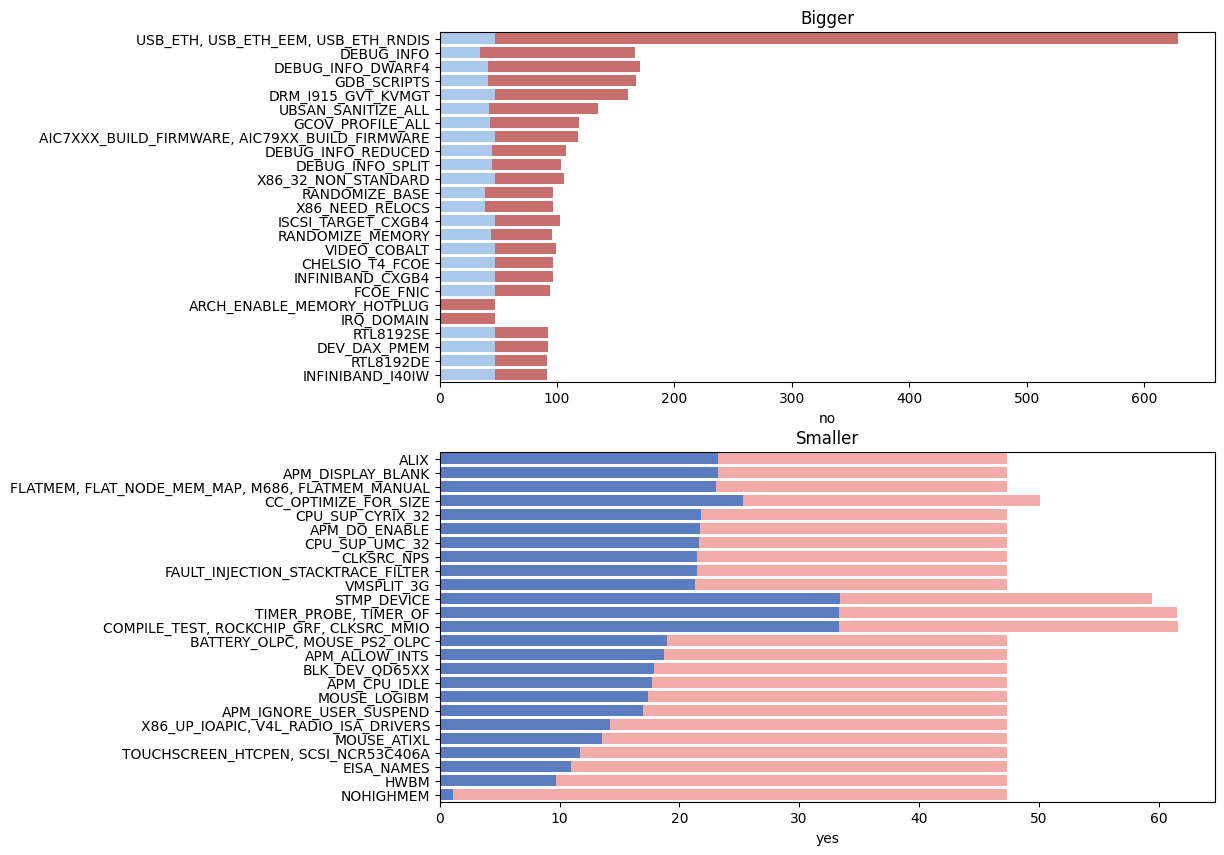

In [55]:
plot_sizes(413)

In [49]:
df_less

,yes,no,diff
ALIX,23.229646,47.337234,-24.107588
APM_DISPLAY_BLANK,23.204735,47.335933,-24.131198
"FLATMEM, FLAT_NODE_MEM_MAP, M686, FLATMEM_MANUAL",23.057437,47.342240,-24.284803
CC_OPTIMIZE_FOR_SIZE,25.312830,50.131201,-24.818372
CPU_SUP_CYRIX_32,21.845079,47.340428,-25.495349
APM_DO_ENABLE,21.736781,47.335198,-25.598418
CPU_SUP_UMC_32,21.612557,47.340206,-25.727649
CLKSRC_NPS,21.515318,47.337158,-25.821841
FAULT_INJECTION_STACKTRACE_FILTER,21.434723,47.334928,-25.900205
VMSPLIT_3G,21.292274,47.340841,-26.048567


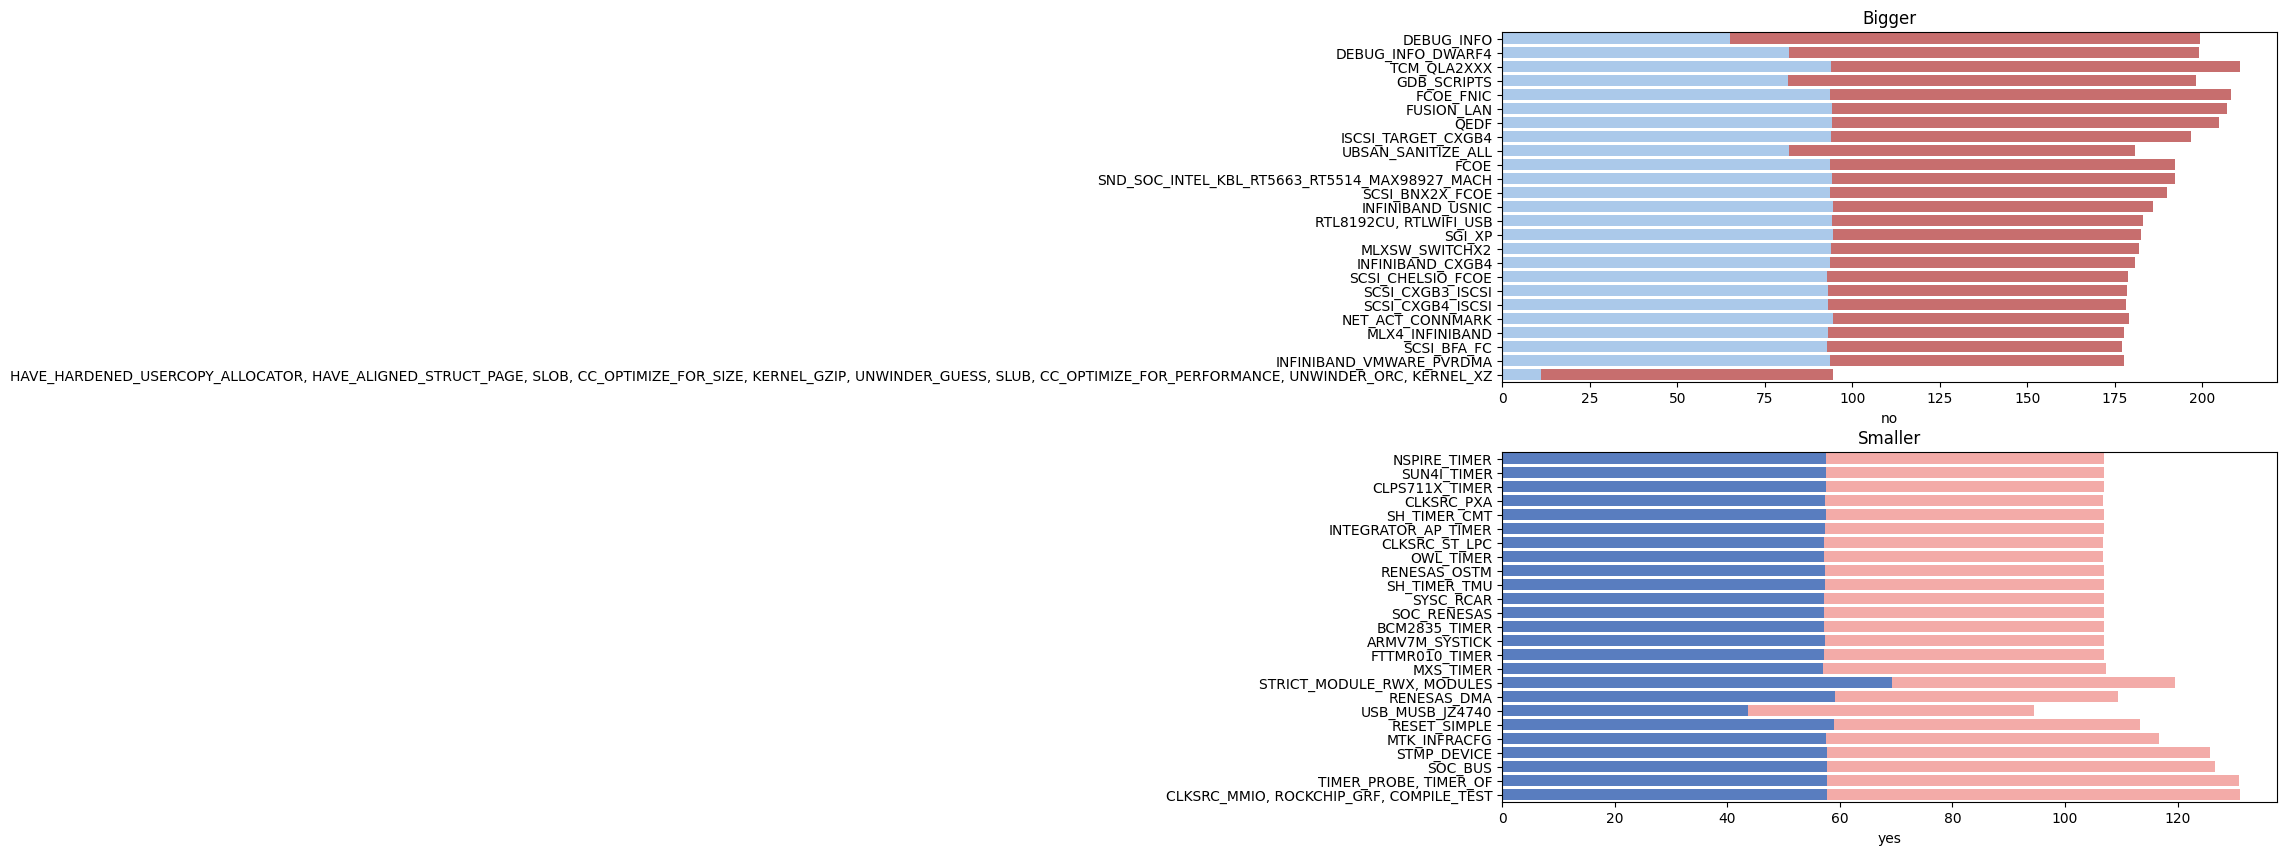

In [56]:
plot_sizes(415)